# <font color='green'>Importing required Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# <font color='green'>Importing Pyspark

In [2]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Regression").getOrCreate()

spark

# <font color='green'>Reading the dataset

In [3]:
path = "Datasets/"
data = spark.read.csv(path + "housing.csv", header = True, inferSchema = True)

In [4]:
data.limit(5).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [6]:
data.count()

20640

In [7]:
data = data.na.drop()

In [8]:
data.count()

20433

In [9]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

# <font color='green'>Vectorizing the features

In [10]:
features_list = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']
features_list.remove('median_house_value')
assembler = VectorAssembler(inputCols = features_list, outputCol = 'features')
data = assembler.transform(data).select('features', 'median_house_value')
data = data.withColumnRenamed('median_house_value','label')

In [11]:
data.limit(5).toPandas()

,features,label
0,"[-122.23, 37.88, 41.0, 880.0, 129.0, 322.0, 12...",452600.0
1,"[-122.22, 37.86, 21.0, 7099.0, 1106.0, 2401.0,...",358500.0
2,"[-122.24, 37.85, 52.0, 1467.0, 190.0, 496.0, 1...",352100.0
3,"[-122.25, 37.85, 52.0, 1274.0, 235.0, 558.0, 2...",341300.0
4,"[-122.25, 37.85, 52.0, 1627.0, 280.0, 565.0, 2...",342200.0


# <font color='green'>Check the Colinearity

In [12]:
data.columns

['features', 'label']

([<matplotlib.axis.YTick at 0x1b7b9b04790>,
 [Text(0, 0.5, 'longitude'),
  Text(0, 1.5, 'latitude'),
  Text(0, 2.5, 'housing_median_age'),
  Text(0, 3.5, 'total_rooms'),
  Text(0, 4.5, 'total_bedrooms'),
  Text(0, 5.5, 'population'),
  Text(0, 6.5, 'households'),
  Text(0, 7.5, 'median_income')])

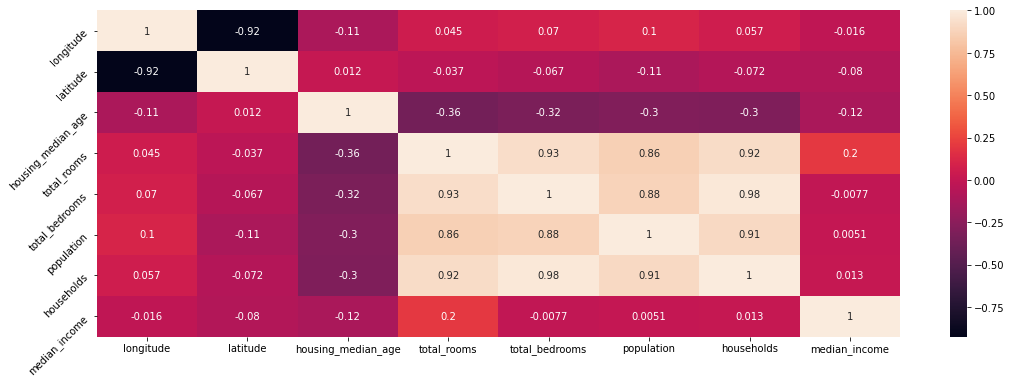

In [13]:
pearson_corr = Correlation.corr(data, 'features', 'pearson').collect()[0][0] # make sure to delete all the NA from the dataset
Corr_matrix = pd.DataFrame(pearson_corr.toArray())
plt.figure(figsize = [18,6])
sns.heatmap(Corr_matrix, annot = True)
plt.xticks(ticks = np.arange(0.5,8,1), labels = features_list)
plt.yticks(ticks = np.arange(0.5,8,1), labels = features_list, rotation = 45)

### There is a high correlation between the columns : "total_rooms", "total_bedrooms", "population" and "households"
### There is also a high negative correlation between the columns "longitude" and "latitude"
### In case of using linear regression we should only consider one of these sets of correlated sets of features

# <font color='green'>Random Split (train-test)

In [14]:
train, test = data.randomSplit([0.7,0.3])

# <font color='green'>Linear Regression

In [15]:
regressor_lr = LinearRegression()
fitModel = regressor_lr.fit(train)
predictions = fitModel.transform(test)

# <font color='green'>Evaluating the predictions

In [16]:
evaluator = RegressionEvaluator(metricName = 'rmse')
rmse = evaluator.evaluate(predictions)
print("The RMSE of this model was {}".format(rmse))

The RMSE of this model was 69051.69761023736


# <font color='green'>Model Parameters

In [17]:
training_summary = fitModel.summary
print("The intercept of Linear Regression was {}".format(fitModel.intercept))
Coef_Matrix = fitModel.coefficients.toArray().tolist()
coef_df = pd.DataFrame(zip(features_list, Coef_Matrix),columns = ['feature','coef'])
coef_df.sort_values('coef').head(10)

The intercept of Linear Regression was -3654625.816275573


,feature,coef
0,longitude,-43449.582187
1,latitude,-42998.776478
5,population,-36.147759
3,total_rooms,-8.303711
6,households,47.010256
4,total_bedrooms,109.967079
2,housing_median_age,1151.379850
7,median_income,40273.379521


## As is shown, longitude and latitude are the most negative correlated features to the label
## Housing_median_age and median_income are on the other hand positively related to the label

# <font color='green'>Model Results

In [18]:
summary = fitModel.summary
test_results = fitModel.evaluate(test)
print("The RMSE of training data : {}".format(summary.rootMeanSquaredError))
print("The RMSE of test data : {}".format(test_results.rootMeanSquaredError))
print("The R2 of training data : {}".format(summary.r2))
print("The R2 of test data : {}".format(test_results.r2))

The RMSE of training data : 69789.87766766202
The RMSE of test data : 69051.69761023736
The R2 of training data : 0.6359880168692222
The R2 of test data : 0.638626863197814


# <font color='green'>Linear Regression + Cross-Validation

In [19]:
regressor_lr_cv = LinearRegression()
param_grid = (ParamGridBuilder().addGrid(regressor_lr_cv.maxIter, [10,15]).addGrid(regressor_lr_cv.regParam, [0.1,0.01])).build()
evaluator = RegressionEvaluator(metricName = 'rmse')
cross_val = CrossValidator(estimator = regressor_lr_cv,
                          estimatorParamMaps = param_grid,
                          evaluator = evaluator,
                          numFolds = 4)
fitModel = cross_val.fit(train)
LR_best_model = fitModel.bestModel

# <font color='green'>Model Parameters

In [20]:
training_summary = LR_best_model.summary
print("The intercept of Linear Regression was {}".format(LR_best_model.intercept))
Coef_Matrix = LR_best_model.coefficients.toArray().tolist()
coef_df_lr_cv = pd.DataFrame(zip(features_list, Coef_Matrix),columns = ['feature','coef'])
coef_df_lr_cv.sort_values('coef').head(10)

The intercept of Linear Regression was -3654574.011981113


,feature,coef
0,longitude,-43448.980415
1,latitude,-42998.217566
5,population,-36.147655
3,total_rooms,-8.303546
6,households,47.012669
4,total_bedrooms,109.963853
2,housing_median_age,1151.388555
7,median_income,40273.361221


# <font color='green'>Model Results 

In [21]:
summary = LR_best_model.summary
test_results = LR_best_model.evaluate(test)
rmse_LR = test_results.rootMeanSquaredError
print("The RMSE of training data : {}".format(summary.rootMeanSquaredError))
print("The RMSE of test data : {}".format(test_results.rootMeanSquaredError))
print("The R2 of training data : {}".format(summary.r2))
print("The R2 of test data : {}".format(test_results.r2))

The RMSE of training data : 69789.87766936852
The RMSE of test data : 69051.69592188459
The R2 of training data : 0.6359880168514207
The R2 of test data : 0.638626880869366


### Conclusion: As is shown, there was a slight influence on the results of linear regression by applying the cross-validation

# <font color = 'green'> Decision Tree + Cross-Validation

In [22]:
regressor_dt = DecisionTreeRegressor()
param_grid = (ParamGridBuilder()\
                                 .addGrid(regressor_dt.maxDepth, [2,5,10])\
                                 .addGrid(regressor_dt.maxBins, [10,20,40])\
                                 .build())
cross_val = CrossValidator(estimator = regressor_dt,
                          estimatorParamMaps = param_grid,
                          evaluator = RegressionEvaluator(metricName = 'rmse'),
                          numFolds = 2)
fitModel = cross_val.fit(train)
DT_best_model = fitModel.bestModel

# <font color = 'green'> Model Results

In [24]:
feature_importance_DT = DT_best_model.featureImportances.toArray()
df_feature_importance_DT = pd.DataFrame(zip(features_list,feature_importance_DT),columns=['feature','importance_dt'])
df_feature_importance_DT.sort_values('importance_dt').head(10)

,feature,importance_dt
6,households,0.007055
4,total_bedrooms,0.012054
3,total_rooms,0.013719
5,population,0.013806
2,housing_median_age,0.061849
1,latitude,0.132852
0,longitude,0.162248
7,median_income,0.596418


In [25]:
predictions = fitModel.transform(test)
rmse_DT = evaluator.evaluate(predictions)
print("The RMSE of test data : {}".format(rmse_DT))

The RMSE of test data : 64970.17129157738


# <font color = 'green'> Random Forest + Cross-Validation

In [26]:
regressor_rf = RandomForestRegressor()

param_grid = (ParamGridBuilder()\
                                 .addGrid(regressor_rf.maxDepth, [2,5,10])\
                                 .addGrid(regressor_rf.maxBins, [5,10,20])\
                                 .addGrid(regressor_rf.numTrees, [5,20]).build())

cross_val = CrossValidator(estimator = regressor_rf,
                           estimatorParamMaps = param_grid,
                           evaluator = evaluator,
                           numFolds = 2)

fitModel = cross_val.fit(train)
RF_best_model = fitModel.bestModel

# <font color = 'green'> Model Results

In [27]:
feature_importance_RF = RF_best_model.featureImportances.toArray()
df_feature_importance_RF = pd.DataFrame(zip(features_list,feature_importance_RF),columns=['feature','importance_rf'])
df_feature_importance_RF.sort_values('importance_rf').head(10)

,feature,importance_rf
6,households,0.023970
4,total_bedrooms,0.026203
3,total_rooms,0.038291
5,population,0.039310
2,housing_median_age,0.068178
0,longitude,0.118801
1,latitude,0.125625
7,median_income,0.559622


In [28]:
predictions = fitModel.transform(test)
rmse_RF = evaluator.evaluate(predictions)
print("The RMSE of test data : {}".format(rmse_RF))

The RMSE of test data : 60655.260230708765


# <font color = 'green'> Gradient Boost Tree + Cross-Validation

In [29]:
regressor_GBT = GBTRegressor()
param_grid = (ParamGridBuilder()\
                                 .addGrid(regressor_GBT.maxDepth,[2,5,10])\
                                 .addGrid(regressor_GBT.maxBins,[5,10,20])\
                                 .build())

cross_val = CrossValidator(estimator = regressor_GBT,
                           estimatorParamMaps = param_grid,
                           evaluator = evaluator,
                           numFolds = 2)

fitModel = cross_val.fit(train)
GBT_best_model = fitModel.bestModel

# <font color = 'green'> Model Results

In [30]:
feature_importance_GBT = GBT_best_model.featureImportances.toArray()
df_feature_importance_GBT = pd.DataFrame(zip(features_list,feature_importance_GBT),columns=['feature','importance_gbt'])
df_feature_importance_GBT.sort_values('importance_gbt').head(10)

,feature,importance_gbt
3,total_rooms,0.012304
6,households,0.025102
2,housing_median_age,0.072983
4,total_bedrooms,0.080107
5,population,0.091384
1,latitude,0.184912
0,longitude,0.193600
7,median_income,0.339608


In [31]:
predictions = fitModel.transform(test)
rmse_GBT = evaluator.evaluate(predictions)
print("The RMSE of test data : {}".format(rmse_GBT))

The RMSE of test data : 58694.20225923566


# <font color = 'green'> Comparing the Regressors

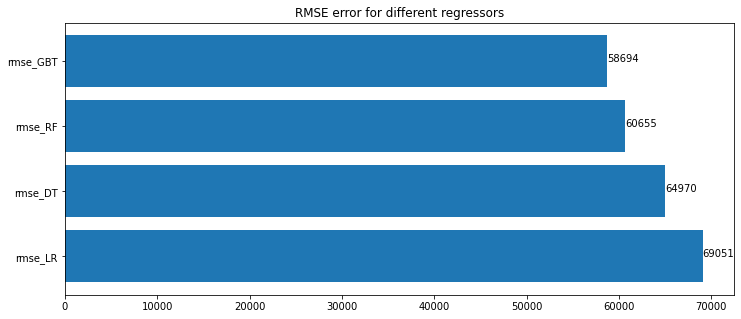

In [39]:
rmse_list = [rmse_LR,rmse_DT,rmse_RF,rmse_GBT]
regressors_names = ["rmse_LR","rmse_DT","rmse_RF","rmse_GBT"]
plt.figure(figsize = [12,5])
plt.barh(np.arange(1,5),rmse_list)
plt.yticks(np.arange(1,5),regressors_names)
plt.title("RMSE error for different regressors")
for i in range(len(rmse_list)):
    plt.annotate(int(rmse_list[i]),(rmse_list[i],i+1))

# <font color = 'green'> Comparing Feature Importance of tree based Regressors

In [59]:
df_importances = pd.concat([df_feature_importance_DT,df_feature_importance_RF.importance_rf, 
                            df_feature_importance_GBT.importance_gbt], axis = 1)

[Text(0, 0, 'longitude'),
 Text(0, 1, 'latitude'),
 Text(0, 2, 'housing_median_age'),
 Text(0, 3, 'total_rooms'),
 Text(0, 4, 'total_bedrooms'),
 Text(0, 5, 'population'),
 Text(0, 6, 'households'),
 Text(0, 7, 'median_income')]

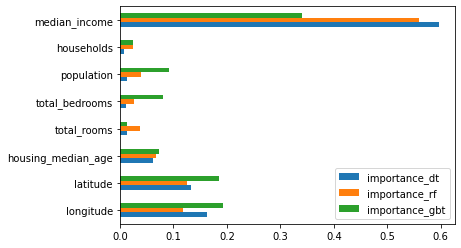

In [75]:
ax = df_importances.plot(kind = 'barh')
ax.set_yticks(np.arange(8))
ax.set_yticklabels(features_list)

## As is shown above, the most influential features on the price of the houses is median_income

## latitude and longitude are the next most important features according to all tree based algorithms